In [63]:
%matplotlib ipympl

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import circmean
from matplotlib.animation import FuncAnimation

import seaborn as sns

from matplotlib import rc
import yaml
import os

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5') # conda create -n newenv -c conda-forge ffmpeg

with open("cal-settings.yml", 'r') as file:
    vars = yaml.safe_load(file)
    RX_TX_SAME_CHANNEL = vars["RX_TX_SAME_CHANNEL"]

print("Cable connections")
if RX_TX_SAME_CHANNEL:
    REF_RX_CH = FREE_TX_CH = 0
    LOOPBACK_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH0 RX\nCH1 TX-->CH1 RX\nCH0 TX -->")
else:
    LOOPBACK_RX_CH = FREE_TX_CH = 0
    REF_RX_CH = LOOPBACK_TX_CH = 1
    print("\nPLL REF-->CH1 RX\nCH1 TX-->CH0 RX\nCH0 TX -->")

loopback_rx_chs = [f"rx_ch{LOOPBACK_RX_CH}_df1", f"rx_ch{LOOPBACK_RX_CH}_df2"]
pll_rx_chs = [f"rx_ch{REF_RX_CH}_df1", f"rx_ch{REF_RX_CH}_df2"] 

Cable connections

PLL REF-->CH0 RX
CH1 TX-->CH1 RX
CH0 TX -->


In [64]:
timestamp = "20240523141330"

usrp1_file = f'data_T03_{timestamp}.txt'
usrp2_file = f'data_T04_{timestamp}.txt'
scope_file = f'data_scope_{timestamp}.txt'

In [65]:
# wrap around function which "glues" together 0 and 360 degrees.

def wraparound(arr):
    arr = np.asarray(arr)
    fltr = arr > 180
    arr[fltr] = arr[fltr] - 360
    return arr

In [66]:
df = pd.read_csv(scope_file, names=[
                 "meas_id", "phase_diff"], header=None, sep=r'\s+')

df.loc[(df['phase_diff'] < 180), 'phase_diff'] = df['phase_diff'].add(360)

df['phase_diff'] -= 360

fields = ["meas_id", "hostname", "meas_type",
          "tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1", "_0", "_1"]

df1 = pd.read_csv(usrp1_file,
                  names=fields, header=None, sep=';')

df2 = pd.read_csv(usrp2_file,
                  names=fields, header=None, sep=';')


# given that we meanly want to plot things, shift the radians to degrees and wrap around
for frame in [df1, df2]:
    for col in ["tx_ch0", "tx_ch1", "rx_ch0", "rx_ch1"]:
        frame.loc[:, col] = wraparound(np.rad2deg(frame[col]))
        


# merge the two dataframes and include the phase diff
merged_df = pd.merge(df1, df2, on=['meas_id', "meas_type"], how='outer',
                     suffixes=('_df1', '_df2'))

merged_df["phase_diff"] = None

# Iterate over rows
for index, row in df.iterrows():
    merged_df.loc[merged_df['meas_id'] ==
                  row['meas_id'], "phase_diff"] = row["phase_diff"]
    


# clean up
df1.drop(columns=["_0", "_1"], inplace=True)
df2.drop(columns=["_0", "_1"], inplace=True)


fltr_pllck = merged_df['meas_type'] == "PLLCK"
fltr_lbck = merged_df['meas_type'] == "LBCK"
fltr_pll = merged_df['meas_type'] == "PLL"
fltr_lb = merged_df['meas_type'] == "LB"

Mean: 8.40°
circ mean: 2.29°


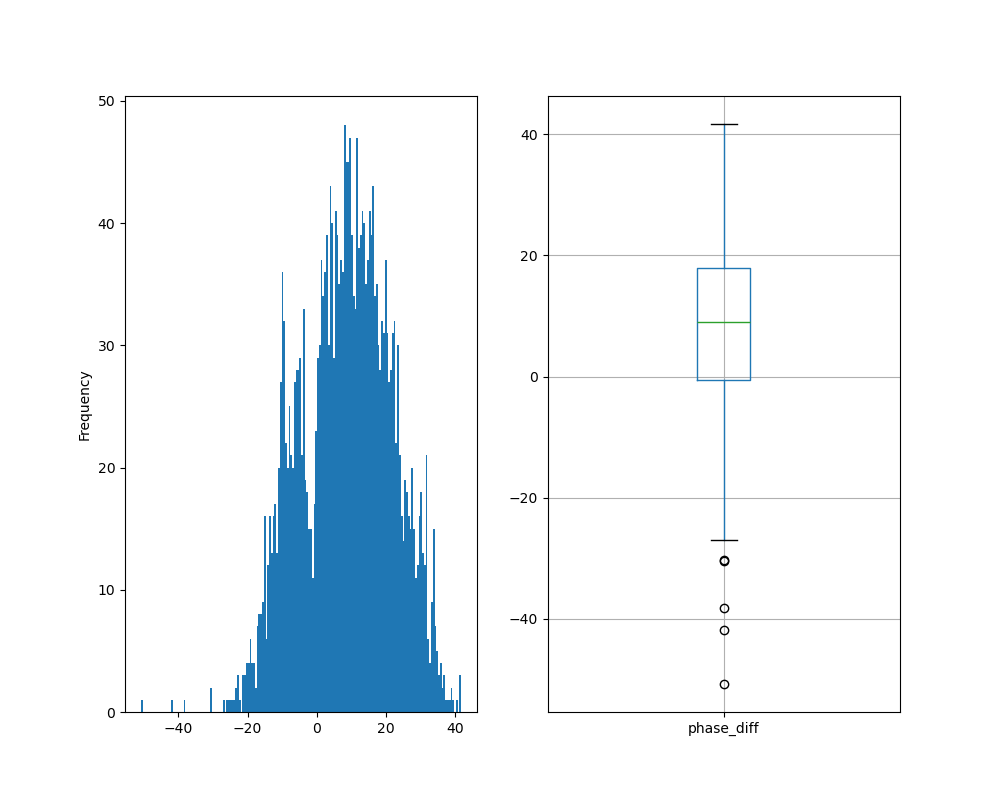

In [67]:
# plot hist and boxplot of the phase difffernce measured by the scope
df.loc[:, 'phase_diff'] = wraparound(df['phase_diff'])

fig, axes = plt.subplots(nrows=1, ncols=2)
df["phase_diff"].plot.hist(figsize=(10, 8), ax=axes[0], bins=180)
df.boxplot(column=['phase_diff'], ax=axes[1])

print(f"Mean: {np.mean(df['phase_diff']):.2f}°")
print(f"circ mean: {circmean(df['phase_diff']):.2f}°")

Check the absolute measured loopback check per USRP. This means read the measured phase after the first phase calibration (i.e., transmitting with $-(\phi_{rx}+\phi_{tx})$).

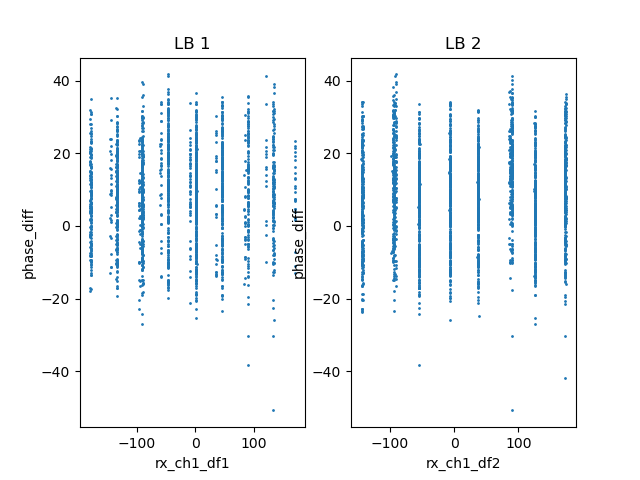

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i, loopback_rx in enumerate(loopback_rx_chs):
    merged_df.where(merged_df['meas_type'] == "LB").plot.scatter(x=loopback_rx,
                                                                   y='phase_diff', title=f"LB {i+1}", ax=axes[i],s=1)

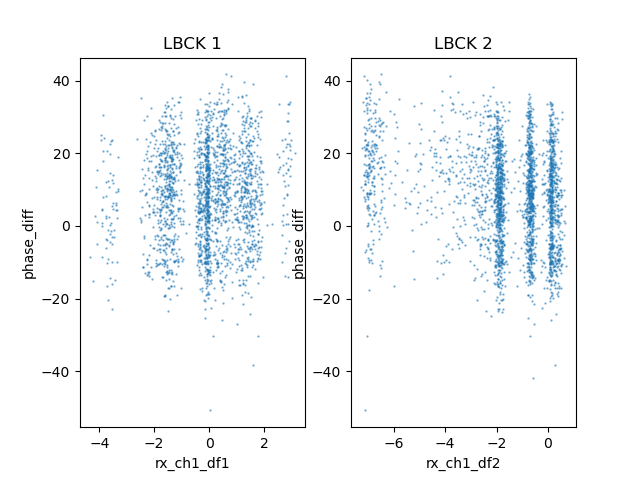

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i, loopback_rx in enumerate(loopback_rx_chs):
    merged_df.where(merged_df['meas_type'] == "LBCK").plot.scatter(x=loopback_rx,
                                                                y='phase_diff', title=f"LBCK {i+1}", ax=axes[i], s=0.5, alpha=0.5);

Check the accumalated absolute measured loopback check of both USRP.

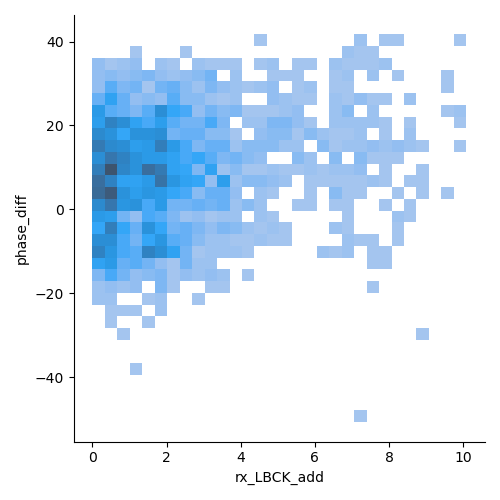

In [79]:
fltr = merged_df['meas_type'] == "LBCK"

merged_df.loc[fltr, 'rx_LBCK_add'] = np.abs(merged_df.loc[fltr, loopback_rx_chs[0]] - merged_df.loc[fltr, loopback_rx_chs[1]])

sns.displot(merged_df, x="rx_LBCK_add", y="phase_diff")

In the following, I am investigating the phase difference when measuring the PLL phase, i.e.,
$$\phi_1 = \phi_{pll}+\phi_{rx, 1}$$
$$\phi_2 = \phi_{pll}+\phi_{rx, 2}$$

I would suspect that due to the dividers in the USRP, $\phi_1$ and $\phi_2$ would overlap when the RX PLLs of both USRPs were aligned (and the received PLL phases are by design aligned). Additionally, 8 clusters of phases should be visible due to the dividers (3 dividers = 2^3 possible phase rotations).

However, we observe that this is not the case and additional, but fixed (in time and power cycle) phase difference between the clusters is observed.

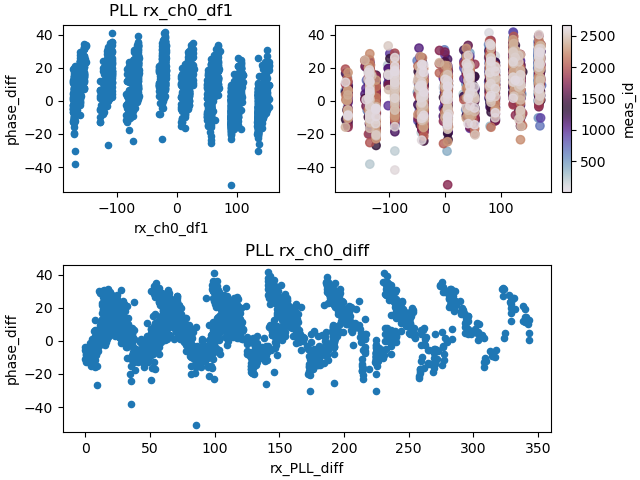

In [71]:
merged_df["rx_PLL_diff"] = np.abs(
    merged_df[pll_rx_chs[0]] - merged_df[pll_rx_chs[1]])

fig, axd = plt.subplot_mosaic([['left', 'right'], ['bottom', 'bottom']],
                              constrained_layout=True);

merged_df.where(fltr_pll).plot.scatter(x=pll_rx_chs[0],
                                                              y='phase_diff', title="PLL rx_ch0_df1", ax=axd['left']);


pll_df = merged_df[merged_df['meas_type'] == 'PLL']

# center = int(np.max(pll_df['meas_id'])//2)


# pll1_df = pll_df[pll_df['meas_id'] < center]
# pll2_df = pll_df[pll_df['meas_id'] >= center]

# sc = axd['right'].scatter(pll1_df['rx_ch0_df2'], pll1_df['phase_diff'],
#                           c="blue", alpha=0.6)
# sc = axd['right'].scatter(pll2_df['rx_ch0_df2'], pll2_df['phase_diff'],
#                           c="red", alpha=0.6)
# axd['right'].set_title('PLL rx_ch0_df2')
# axd['right'].set_xlabel('rx_ch0_df2')
# axd['right'].set_ylabel('phase_diff')

sc = axd['right'].scatter(pll_df[pll_rx_chs[1]], pll_df['phase_diff'],
                          c=pll_df['meas_id'], cmap='twilight', alpha=0.8)
# Add a color bar to show the scale of meas_id
plt.colorbar(sc, label='meas_id')

# merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x='rx_ch0_df2',
#                                                               y='phase_diff', title="PLL rx_ch0_df2", ax=axd['right'], c="red");

merged_df.where(merged_df['meas_type'] == "PLL").plot.scatter(x='rx_PLL_diff',
                                                              y='phase_diff', title="PLL rx_ch0_diff", ax=axd['bottom']);

Cluster centers:
 [ 139.16789073 -114.55105851   17.50044398 -165.05604105   58.5252006
  -69.78396553   95.62960716  -21.50219147]
Cluster labels:
 [6 1 7 ... 1 6 6]
Cluster centers:
 [-165.05604105 -114.55105851  -69.78396553  -21.50219147   17.50044398
   58.5252006    95.62960716  139.16789073]
[50.50498254290595, 44.76709297714305, 48.28177406140152, 39.00263545539073, 41.02475662096059, 37.10440655162478, 43.53828357247373]
Cluster centers:
 [   3.60024241  128.41752379 -138.36723145  -40.95529927  -90.34339941
  169.4095873    84.27789013   43.80123371]
Cluster labels:
 [7 2 3 ... 4 3 2]
Cluster centers:
 [-138.36723145  -90.34339941  -40.95529927    3.60024241   43.80123371
   84.27789013  128.41752379  169.4095873 ]
[48.023832036493104, 49.3881001446218, 44.55554167539958, 40.20099129805033, 40.47665642704653, 44.1396336543133, 40.99206351038009]


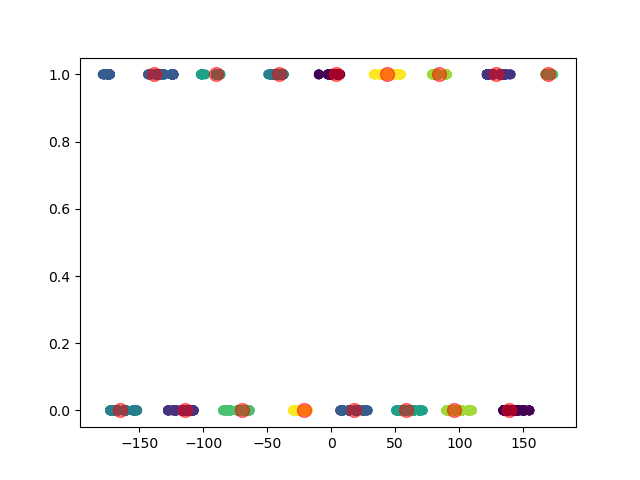

In [72]:

ax = sns.histplot(data=merged_df.loc[fltr_pll, :], x=pll_rx_chs[0], bins=52,kde=True);
sns.histplot(data=merged_df.loc[fltr_pll, :], x=pll_rx_chs[1], ax=ax, bins=52,kde=True);

from sklearn.cluster import KMeans

array = df1.loc[fltr_pll, "rx_ch0"].values

# Reshape array for KMeans
array_reshaped = array.reshape(-1, 1)

# Apply KMeans with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(array_reshaped)

# Get the cluster labels
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_.flatten()

# Print the results
print("Cluster centers:\n", centers)
print("Cluster labels:\n", labels)

sorted_clusters  = np.sort(centers)
print("Cluster centers:\n", sorted_clusters)
differences = [sorted_clusters[i + 1] - sorted_clusters[i] for i in range(len(sorted_clusters) - 1)]
print(differences)


plt.figure()
# Optional: Visualize the clusters
plt.scatter(array, np.zeros_like(array), c=labels, cmap='viridis')
plt.scatter(centers, np.zeros_like(centers), c='red', s=100, alpha=0.5)


array = df2.loc[fltr_pll, "rx_ch0"].values

# Reshape array for KMeans
array_reshaped = array.reshape(-1, 1)

# Apply KMeans with 8 clusters
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(array_reshaped)

# Get the cluster labels
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_.flatten()

# Print the results
print("Cluster centers:\n", centers)
print("Cluster labels:\n", labels)

# Group elements by their cluster labels
clusters = {i: array[labels == i] for i in range(8)}

# Compute average value per cluster
cluster_averages = {i: np.mean(cluster) for i, cluster in clusters.items()}

sorted_clusters  = np.sort(centers)
print("Cluster centers:\n", sorted_clusters)
differences = [sorted_clusters[i + 1] - sorted_clusters[i] for i in range(len(sorted_clusters) - 1)]
print(differences)

# Optional: Visualize the clusters
plt.scatter(array, np.ones_like(array), c=labels, cmap='viridis')
plt.scatter(centers, np.ones_like(centers), c='red', s=100, alpha=0.5)
plt.show()

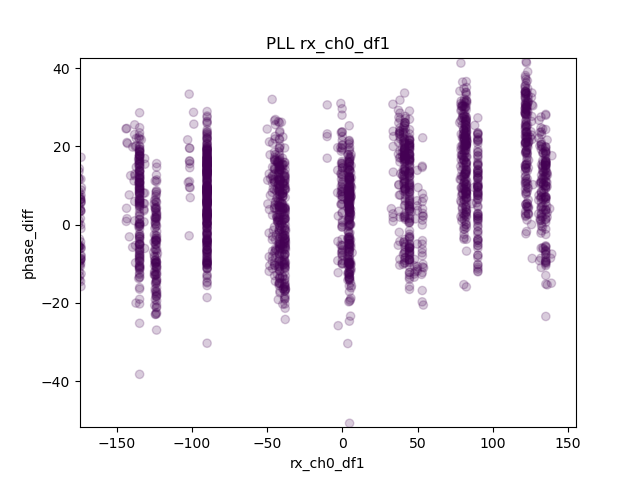

In [73]:

fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.2)
ax.set_xlim(pll_df['rx_ch0_df1'].min() - 1, pll_df['rx_ch0_df1'].max() + 1)
ax.set_ylim(pll_df['phase_diff'].min() - 1, pll_df['phase_diff'].max() + 1)
# plt.colorbar(sc, ax=ax, label='meas_id')
ax.set_title('PLL rx_ch0_df1')
ax.set_xlabel('rx_ch0_df1')
ax.set_ylabel('phase_diff')

# Step 3: Define the initialization function


def init():
    sc.set_offsets(np.empty((0, 2)))
    return sc,

# Step 4: Define the animation function


def animate(i):
    current_df = pll_df[pll_df['meas_id'] <= i]
    # current_df = current_df[current_df['meas_id'] > (i-200)]
    sc.set_offsets(current_df.loc[:, ['rx_ch0_df2', 'phase_diff']], )
    sc.set_array(current_df['meas_id'])
    # alphas = (current_df['meas_id'] / i).values
    # colors = np.zeros((len(current_df), 4))
    # colors[:, 0] = 1  # Set red color
    # colors[:, 3] = alphas  # Set alpha based on meas_id
    # sc.set_array(colors)
    return sc,


max_meas_id = int(pll_df['meas_id'].max())

# Step 5: Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=np.arange(1, max_meas_id + 1, step=100), interval=400, blit=True)

anim

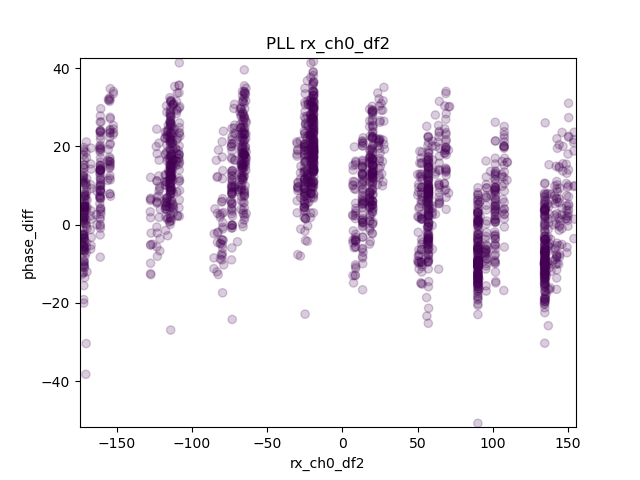

In [74]:
# Step 2: Create the plot
fig, ax = plt.subplots()
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.2)
ax.set_xlim(pll_df['rx_ch0_df1'].min() - 1, pll_df['rx_ch0_df1'].max() + 1)
ax.set_ylim(pll_df['phase_diff'].min() - 1, pll_df['phase_diff'].max() + 1)
# plt.colorbar(sc, ax=ax, label='meas_id')
ax.set_title('PLL rx_ch0_df2')
ax.set_xlabel('rx_ch0_df2')
ax.set_ylabel('phase_diff')

# Step 3: Define the initialization function


def init():
    sc.set_offsets(np.empty((0, 2)))
    return sc,

# Step 4: Define the animation function


def animate(i):
    current_df = pll_df[pll_df['meas_id'] <= i]
    # current_df = current_df[current_df['meas_id'] > (i-200)]
    sc.set_offsets(current_df.loc[:,['rx_ch0_df1', 'phase_diff']], )
    sc.set_array(current_df['meas_id'])
    # alphas = (current_df['meas_id'] / i).values
    # colors = np.zeros((len(current_df), 4))
    # colors[:, 0] = 1  # Set red color
    # colors[:, 3] = alphas  # Set alpha based on meas_id
    # sc.set_array(colors)
    return sc,

max_meas_id = int(pll_df['meas_id'].max())

# Step 5: Create the animation
anim = FuncAnimation(fig, animate, init_func=init,
                    frames=np.arange(1,max_meas_id + 1,step=100), interval=400, blit=True)

anim

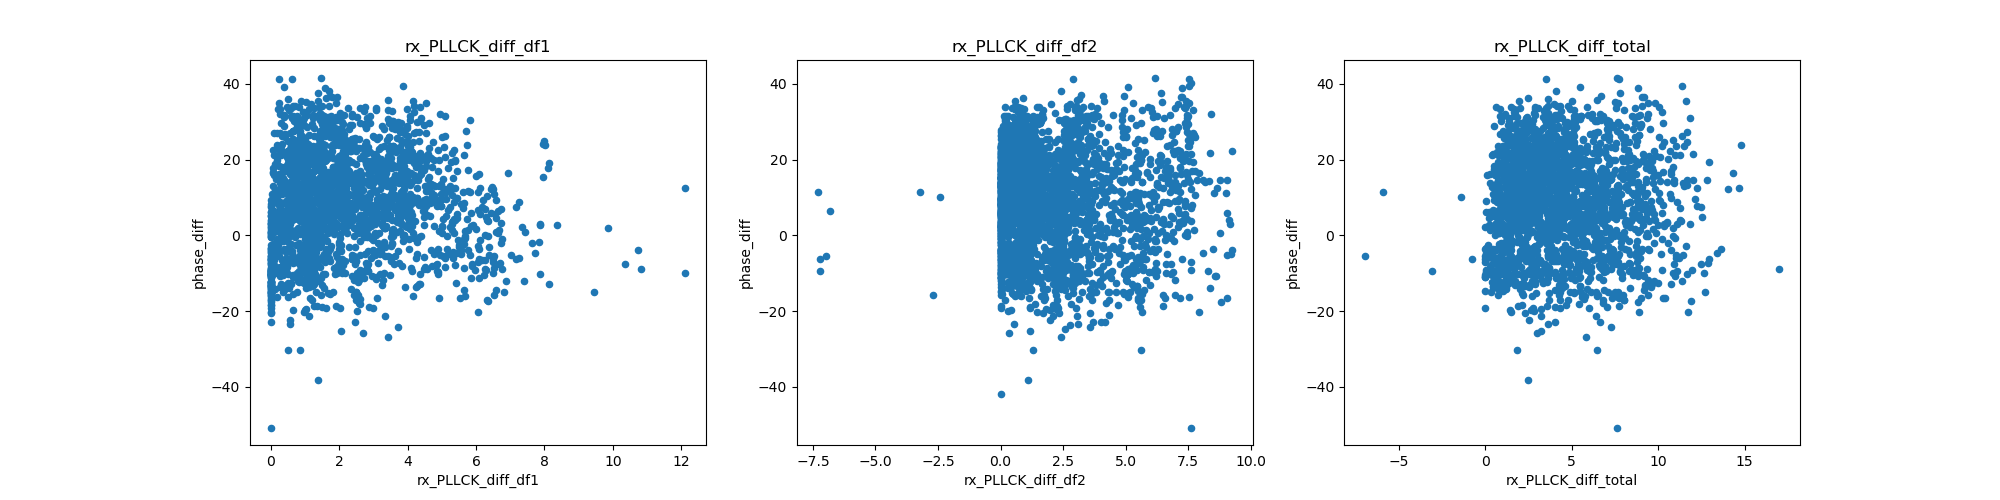

In [75]:
# PLLCK RX0 and RX1 should have approx the same value


fltr = merged_df['meas_type'] == "PLLCK"

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
for i in [1,2]:

    merged_df.loc[fltr, f'rx_PLLCK_diff_df{i}'] = wraparound(np.abs(
        merged_df.loc[fltr, loopback_rx_chs[i-1]] - merged_df.loc[fltr, pll_rx_chs[i-1]]))

    merged_df.plot.scatter(x=f'rx_PLLCK_diff_df{i}', y='phase_diff',
                           title=f'rx_PLLCK_diff_df{i}', ax=axes[i-1]);
merged_df.loc[fltr, f'rx_PLLCK_diff_total'] = merged_df.loc[fltr,
                                                            f'rx_PLLCK_diff_df1'] + merged_df.loc[fltr, f'rx_PLLCK_diff_df2']
merged_df.plot.scatter(x='rx_PLLCK_diff_total', y='phase_diff',
                       title='rx_PLLCK_diff_total', ax=axes[-1]);